In [1]:
%load_ext autoreload

%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pykep as pk 
import deepxde as dde

from scipy.integrate import odeint
from icecream import ic
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm
from Visualise_Tools import set_size, format_axes
from OrbMech_Utilities import plot3D_grav
from matplotlib.ticker import PercentFormatter


import pandas as pd
from scipy import stats 
import pickle
import matplotlib as mpl

from astropy import units as u
import astropy
import ast

from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import cowell, propagate
from poliastro.maneuver import Maneuver
from poliastro.iod import izzo

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



## Heatmaps
Can be edited to provide both the computational efficiency as well as loss values heatmaps

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


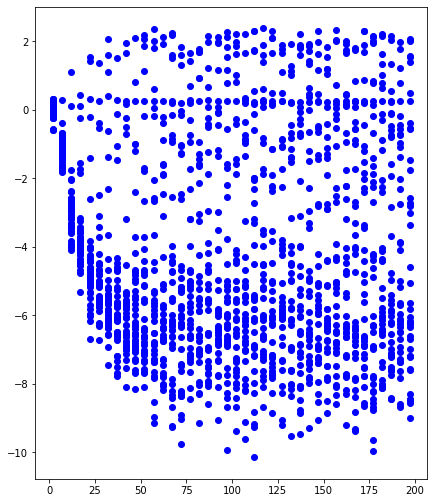

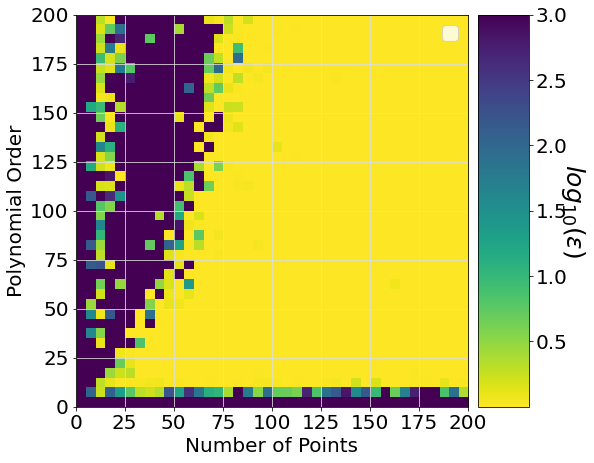

In [3]:

cmaps = [ 'RdYlBu_r', 'RdYlGn_r', 'gray_r']

norm = mpl.colors.Normalize(vmin=-1, vmax=1)

pd.set_option('display.max_rows', 40)
with open('Point_Order_SweepELM.pkl', 'rb') as file:
    DF = pickle.load(file)

DF['CompEff2'] = DF['Loss']*DF['Training Time']**2

pivot2 = pd.pivot_table(DF, values='CompEff2', index = 'poly_order', columns='points')

# df.sort_values('Loss')
# pivot.iloc[18][198]=1e-16
# fig = plt.figure(figsize=set_size(483.69687*1.05, 1, subplots = (2,1)))
# ax = plt.gca()

sub_DF = DF[DF['points']==108]
# display(DF)
# ax.scatter(sub_DF['poly_order'], np.log10(sub_DF['CompEff2']))

fig = plt.figure(figsize=set_size(483.69687*1.05, 1, subplots = (2,1)))
ax = plt.gca()

for i in range(3,200):
    sub_DF = DF[DF['points']==i]
    ax.scatter(sub_DF['poly_order'], np.log10(sub_DF['Loss']), color='b')




fig = plt.figure(figsize=set_size(483.69687*1.05, 1, subplots = (2,1)))
ax = plt.gca()
img = ax.imshow(pivot2, origin = 'lower', interpolation='nearest', extent=[0,200,0,200], cmap='viridis_r', vmax=3)
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
format_axes(ax=ax, fontsize=20, ylabel = 'Polynomial Order', xlabel=r'Number of Points')

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.1,ax.get_position().height])
cbar = plt.colorbar(img, cax=cax, )
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel(r'$log_{10}(\epsilon)$', rotation=270, fontsize=25)
cbar.ax.tick_params(labelsize=20) 
# fig.savefig('./Plot/HeatMap.pdf', bbox_inches='tight')
# ax.set_xticklabels(range(0,200,10))
# ax.set_yticklabels(pivot.columns[0:-1:4])



## Monte Carlo Loss value distribution for XTFC

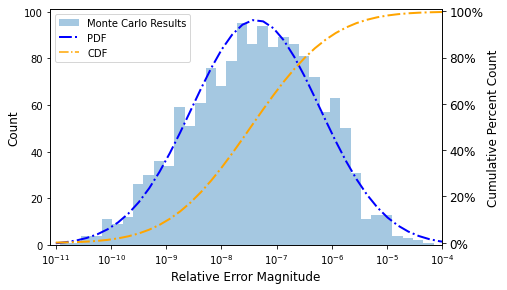

In [4]:
import numpy as np
import matplotlib.pyplot as plt

### Code from https://stackoverflow.com/questions/35001607/scaling-and-fitting-to-a-log-normal-distribution-using-a-logarithmic-axis-in-pyt

with open('Seed_Training_DF.pkl', 'rb') as file:
    df = pickle.load(file)
    
# generate log-normal distributed set of samples
np.random.seed(42)
# samples = np.random.lognormal(mean=1, sigma=.4, size=10000)
samples=df['Loss']
N_bins = 50

# make a fit to the samples
shape, loc, scale = stats.lognorm.fit(samples, floc=0)
x_fit       = np.linspace(samples.min(), samples.max(), 100)
samples_fit = stats.lognorm.pdf(x_fit, shape, loc=loc, scale=scale)

# plot a histrogram with linear x-axis
fig = plt.figure(figsize=set_size(483.69687*1.05, 1, subplots = (1,1)))
ax2 = plt.gca()

# equally sized bins in log10-scale and centers
bins_log10 = np.logspace(np.log10(samples.min()), np.log10(samples.max()), N_bins)
bins_log10_cntr = (bins_log10[1:] + bins_log10[:-1]) / 2

# histogram plot
counts, bin_edges, ignored = ax2.hist(samples, bins_log10, histtype='stepfilled', alpha=0.4,
                                      label='Monte Carlo Results')

# calculate length of each bin and its centers(required for scaling PDF to histogram)
bins_log_len = np.r_[bin_edges[1:] - bin_edges[: -1], 0]
bins_log_cntr = bin_edges[1:] - bin_edges[:-1]

# get pdf-values for same intervals as histogram
samples_fit_log = stats.lognorm.pdf(bins_log10, shape, loc=loc, scale=scale)

# pdf-values for centered scale
samples_fit_log_cntr = stats.lognorm.pdf(bins_log10_cntr, shape, loc=loc, scale=scale)

# pdf-values using cdf 
samples_fit_log_cntr2_ = stats.lognorm.cdf(bins_log10, shape, loc=loc, scale=scale)
samples_fit_log_cntr2 = np.diff(samples_fit_log_cntr2_)

# # plot fitted and scaled PDFs into histogram
# ax2.plot(bins_log10, 
#          samples_fit_log * bins_log_len * counts.sum(), '-', 
#          label='PDF with edges',  linewidth=2)

# ax2.plot(bins_log10_cntr, 
#          samples_fit_log_cntr * bins_log_cntr * counts.sum(), '-', 
#          label='PDF with centers', linewidth=2)

ax2.plot(bins_log10_cntr, 
         samples_fit_log_cntr2 * counts.sum(), 'b-.', 
         label='PDF', linewidth=2)
ax2.plot([], [], '-.', color='orange', label = 'CDF')

ax3 = ax2.twinx()

ax3.plot(bins_log10_cntr, 
         np.cumsum(samples_fit_log_cntr2 * counts.sum())/1500, '-.', color='orange', 
         label='CDF', linewidth=2)
ax3.yaxis.set_major_formatter(PercentFormatter(1))


ax2.set_xscale('log')
ax2.set_xlim(bin_edges.min(), 10**-4)
format_axes(ax=ax2, fontsize=12, xlabel = r'Relative Error Magnitude', ylabel=r'Count')

ax3.set_ylim(-0.01, 1.01)
format_axes(ax=ax3, fontsize=12, xlabel = r'Relative Error Magnitude', ylabel=r'Cumulative Percent Count')

ax2.legend(loc=2)
ax3.get_legend().remove()
plt.minorticks_off()
plt.show()

fig.savefig('./Plot/Seed_Error.pdf', bbox_inches='tight')


## Run Time Scaling for XTFC and TFC

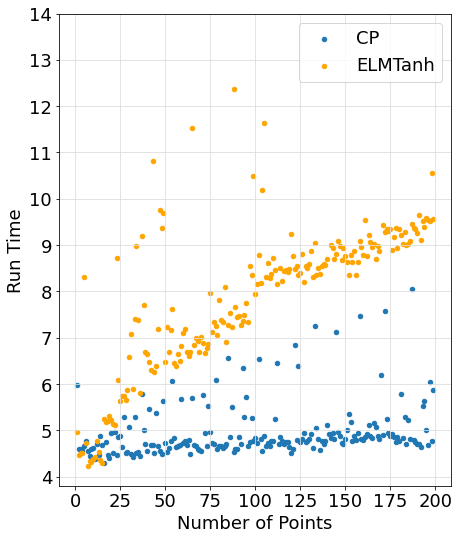

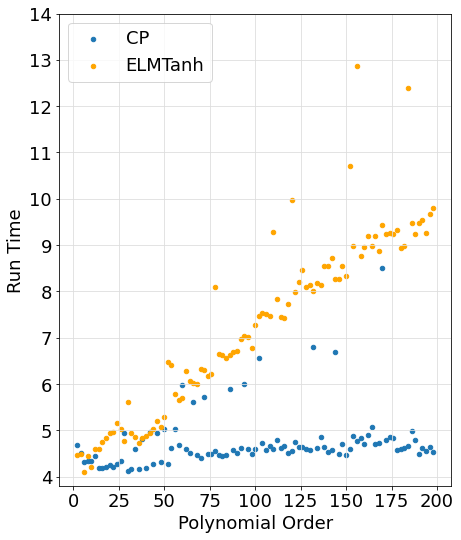

In [5]:
import pandas as pd
import pickle

pd.set_option('display.max_rows', 20)
with open('RunTimeComparisonPoints.pkl', 'rb') as file:
    df = pickle.load(file)

fig = plt.figure(figsize=set_size(483.69687*1.05, 1, subplots = (2,1)))
ax = plt.gca()

df.query('basis_function=="CP"').plot(x='points', y='Training Time', kind='scatter', ax=ax, label='CP',marker='o')
df.query('basis_function=="ELMTanh"').plot(x='points', y='Training Time', kind='scatter', color='orange', ax=ax, label='ELMTanh', marker='o')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.set_yticks(np.linspace(4,16,13))
ax.set_ylim(3.8, 14)

format_axes(ax=ax, fontsize=18, xlabel = r'Number of Points', ylabel=r'Run Time')

fig.savefig('./Plot/RunTimeComparisonPoints.pdf', bbox_inches='tight')

pd.set_option('display.max_rows', 20)
with open('RunTimeComparison.pkl', 'rb') as file:
    df = pickle.load(file)

fig = plt.figure(figsize=set_size(483.69687*1.05, 1, subplots = (2,1)))
ax = plt.gca()

df.query('basis_function=="CP"').plot(x='poly_order', y='Training Time', kind='scatter', ax=ax, label='CP', marker='o')
df.query('basis_function=="ELMTanh"').plot(x='poly_order', y='Training Time', kind='scatter', color='orange', ax=ax, label='ELMTanh', marker='o')

format_axes(ax=ax, fontsize=18, xlabel = r'Polynomial Order', ylabel=r'Run Time')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.set_yticks(np.linspace(4,16,13))
ax.set_ylim(3.8, 14)

fig.savefig('./Plot/RunTimeComparison.pdf', bbox_inches='tight')



## Monte Carlo Run Time distribution for XTFC

,poly_order,points,poly_remove,Example,Loss,Training Time,CompEff,Passed 1e-10,Passed 1e-12,Passed 1e-13
count,921.000000,921.0,921.0,921.000000,9.210000e+02,921.000000,9.210000e+02,921.000000,921.000000,921.000000
mean,49.971770,51.0,2.0,474.161781,1.016518e-01,3.468820,2.708386e-01,0.968512,0.966341,0.965255
std,9.013231,0.0,0.0,297.918815,1.746987e+00,0.400355,4.257786e+00,0.174726,0.180448,0.183232
min,2.000000,51.0,2.0,0.000000,5.560548e-16,2.789984,4.056572e-16,0.000000,0.000000,0.000000
25%,50.000000,51.0,2.0,216.000000,5.560548e-16,3.170858,6.797656e-16,1.000000,1.000000,1.000000
50%,50.000000,51.0,2.0,473.000000,5.560548e-16,3.326805,1.374207e-15,1.000000,1.000000,1.000000
75%,50.000000,51.0,2.0,731.000000,5.560548e-16,3.702947,2.731507e-15,1.000000,1.000000,1.000000
max,190.000000,51.0,2.0,999.000000,4.938358e+01,4.499208,1.136951e+02,1.000000,1.000000,1.000000


921


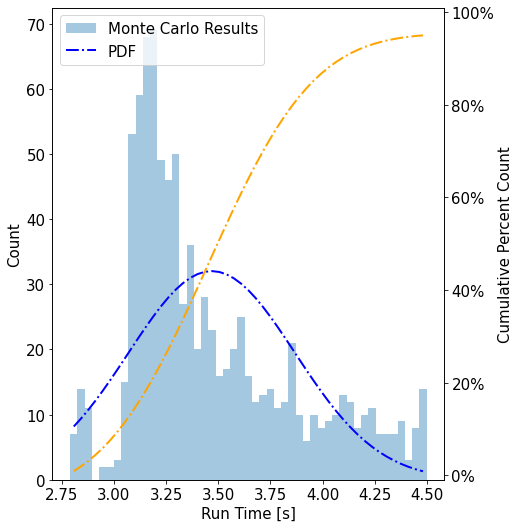

In [9]:
pd.set_option('display.max_rows', 20)
with open('RunTimeComparison.pkl', 'rb') as file:
    df = pickle.load(file)

# df = df.iloc[500:1499]
df = df[df['Training Time']<4.5]
display(df.describe())
print(len(df))


# TrainingStats = df.groupby(['Shortway', 'basis_function', 'method', 'poly_order', 'points', 'poly_remove'])['Loss', 'Training Time', 'CompEff'].mean()
# TrainingStats[['Percent 1e-10', 
#                 'Percent 1e-12', 
#                 'Percent 1e-13']] = df.groupby(['Shortway', \
#                                                             'basis_function', \
#                                                             'method', \
#                                                             'poly_order', \
#                                                             'points', \
#                                                             'poly_remove'])[['Passed 1e-10', 'Passed 1e-12', 'Passed 1e-13']].mean()*100

# fig = plt.figure(figsize=set_size(483.69687*1.05, 1, subplots = (1,1)))
# ax = plt.gca()

# df.query('basis_function=="LeP"').plot(x='poly_order', y='Training Time', kind='hist', ax=ax, label='CP')
# df.query('basis_function=="ELMTanh"').plot(x='poly_order', y='Training Time', kind='scatter', color='orange', ax=ax, label='ELMTanh')

# format_axes(ax=ax, fontsize=12, xlabel = r'Polynomial Order', ylabel=r'Run Time')

# fig.savefig('./Plot/RunTimeComparison.pdf', bbox_inches='tight')



import matplotlib.mlab as mlab

# generate log-normal distributed set of samples
np.random.seed(42)
# samples = np.random.lognormal(mean=1, sigma=.4, size=10000)
samples=df['Training Time']
N_bins = 50

# make a fit to the samples
loc, scale = stats.norm.fit(samples)
x_fit       = np.linspace(samples.min(), samples.max(), 100)
samples_fit = stats.norm.pdf(x_fit, loc=loc, scale=scale)

# plot a histrogram with linear x-axis
fig = plt.figure(figsize=set_size(483.69687*1.05, 1, subplots = (2,1)))
ax2 = plt.gca()

# equally sized bins in log10-scale and centers
bins_log10 = np.linspace(samples.min(), samples.max(), N_bins)
bins_log10_cntr = (bins_log10[1:] + bins_log10[:-1]) / 2

# histogram plot
counts, bin_edges, ignored = ax2.hist(samples, bins_log10, histtype='stepfilled', alpha=0.4,
                                      label='Monte Carlo Results')

samples_fit = stats.norm.cdf(bins_log10, loc=loc, scale=scale)
samples_fit = np.diff(samples_fit)

ax2.plot(bins_log10_cntr, 
         samples_fit * counts.sum(), 'b-.', 
         label='PDF', linewidth=2)

# ax2.set_xscale('log')
# ax2.set_xlim(bin_edges.min(), 10**-4)
format_axes(ax=ax2, fontsize=15, xlabel = r'Run Time [s]', ylabel=r'Count')

ax3 = ax2.twinx()
ax3.set_ylim(-0.01, 1.01)
ax3.plot(bins_log10_cntr, 
         np.cumsum(samples_fit), '-.', color='orange', 
         label='CDF', linewidth=2)

ax3.yaxis.set_major_formatter(PercentFormatter(1))
format_axes(ax=ax3, fontsize=15 , xlabel = r'Run Time [s]', ylabel=r'Cumulative Percent Count')

ax2.legend(loc=2, prop={'size':15})
ax3.get_legend().remove()
plt.minorticks_off()
plt.show()  


fig.savefig('./Plot/RunTimeDistribution.pdf', bbox_inches='tight')